In [1]:
import pickle
import pandas as pd
import numpy as np
import gc; gc.enable()
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, load_npz, csr_matrix

In [2]:
drop_cols = ['price_binned_dp_mean_enc', 'image_top_1_dp_mean_enc', 'item_seq_number_dp_mean_enc']

In [3]:
with open("all_features_dense.pickle", 'rb') as handle:
    comm_features = pickle.load(handle)
    comm_features.drop(drop_cols, axis=1, inplace=True)
    
with open("TF_IDF_W_BIN_C/tf_idf_features(with_bin).pickle", 'rb') as handle:
    text_features = pickle.load(handle)

In [4]:
comm_features

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,user_type,...,parent_category_name_param_3,category_name_param_1,category_name_param_2,category_name_param_3,parent_category_name_region,category_name_region,Weekday,image_top_1_mean_price,item_seq_number_mean_price,price_binned
0,17,994,4,10,104,88,130,0.486577,0.284494,1,...,18,4,85,563,121,38,2,0.858789,0.838000,14
1,6,186,0,41,41,225,604,0.439237,0.249218,1,...,1,337,252,684,24,982,2,0.847451,0.844113,3
2,15,562,4,29,119,88,100,0.518554,0.325533,1,...,5,148,156,629,119,575,2,0.835731,0.830898,24
3,14,851,3,43,33,73,604,0.476137,0.298728,1,...,4,353,257,686,90,1020,2,0.763051,0.839457,11
4,27,1308,4,29,192,107,604,0.518554,0.262826,1,...,41,149,142,652,132,588,2,0.803204,0.842333,24
5,6,436,4,29,119,88,106,0.500291,0.239971,1,...,8,148,156,632,136,592,2,0.796170,0.847105,19
6,6,1208,0,41,24,73,604,0.479975,0.874749,2,...,1,324,253,684,24,982,2,0.826854,0.698788,12
7,22,1137,5,15,240,0,610,0.700911,0.262826,1,...,74,32,97,604,155,184,2,0.960723,0.842333,57
8,14,195,3,20,113,73,604,-1.000000,0.303342,1,...,4,76,124,613,90,343,2,0.854833,0.835163,0
9,1,0,2,35,33,73,604,0.300465,0.249218,1,...,3,204,241,677,57,765,2,0.948405,0.844113,1


In [5]:
cat_col = [
    'region',
    'city',
    'parent_category_name',
    'category_name',
    'param_1',
    'param_2',
    'param_3',
    'user_type',
    'image_top_1',
    'region_city',
    'parent_category_name_category_name',
    'parent_category_name_param_1',
    'parent_category_name_param_2',
    'parent_category_name_param_3',
    'category_name_param_1',
    'category_name_param_2',
    'category_name_param_3',
    'category_name_region',
    'Weekday',
    'price_binned'
] 

In [6]:
features = comm_features.columns.tolist()
features.extend(['f_'+str(i) for i in range(text_features.shape[1])])

In [7]:
all_features = hstack([csr_matrix(comm_features), text_features]).tocsr()

In [8]:
train_y = pd.read_csv("regression_target.csv")
train_y = train_y['deal_probability'].values
train_len = train_y.shape[0]
print(train_len)

1503424


In [9]:
PLOT_CORR = False

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

if PLOT_CORR is True:
    f, ax = plt.subplots(figsize=[10,7])
    sns.heatmap(pd.concat([comm_features.loc[:,[x for x in comm_features.columns if x not in cat_col]], 
                           pd.read_csv("regression_target.csv")['deal_probability']], axis=1).corr(),
                annot=False, fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'},cmap="plasma",ax=ax, linewidths=.01)
    ax.set_title("Dense Features Correlation Matrix")
    plt.savefig('correlation_matrix.png')

In [11]:
del comm_features, text_features; gc.collect()

0

In [12]:
train_features = all_features[:train_len, :]
del all_features; gc.collect()

0

In [13]:
print(train_features.shape)
from sklearn.model_selection import train_test_split
train_index, valid_index = train_test_split(np.arange(train_features.shape[0]), test_size=0.1, random_state=519)

tr_X, tr_y = train_features[train_index, :], train_y[train_index]
val_X, val_y = train_features[valid_index, :], train_y[valid_index]
print(tr_X.shape, val_X.shape)

(1503424, 100118)
(1353081, 100118) (150343, 100118)


In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GridSearchCV, ParameterGrid, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from copy import deepcopy as cp
from wordbatch.models import FM_FTRL

In [15]:
def clip_rmse(ground_truth, predictions):
    predictions = np.clip(predictions, 0., 1.)
    return mean_squared_error(ground_truth, predictions)**.5

clip_rmse_scorer = make_scorer(clip_rmse, greater_is_better=False)

In [16]:
from sklearn.model_selection import ParameterGrid
from copy import deepcopy as cp
import lightgbm as lgb

def fit_params(default_params, params, tr_X, tr_y, val_X, val_y):
    params_list = ParameterGrid(params)
    best_param = None
    best_loss = None
    for param in params_list:
        used_params = cp(default_params)
        used_params.update(param)
        model = lgb.LGBMRegressor(**used_params)
        model.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y), (val_X, val_y)], eval_names=['train', 'valid'], 
                  early_stopping_rounds=200, verbose=100, 
                  feature_name=features, categorical_feature=list(cat_col), eval_metric='rmse')
        val_pred = model.predict(val_X)
        loss = mean_squared_error(val_y, np.clip(val_pred, 0., 1.))**.5
        
        print(str(param)+'\nloss:{:.6f}'.format(loss))
        if best_loss is None or loss < best_loss:
            best_loss = loss
            best_param = param
        del val_pred; gc.collect()
        
    print('Best params:', str(best_param), '\n', 'best loss:', best_loss)

In [17]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':200, 
    'min_split_gain':0.0, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':0.8, 
    'subsample_freq':1, 
    'colsample_bytree':0.8, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':719, 
    'n_job': 4
}

try_params = {
    'boosting_type': ['gbdt', 'dart']
}

fit_params(default_params, try_params, tr_X, tr_y, val_X, val_y)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223412	valid's rmse: 0.226289
[200]	train's rmse: 0.220115	valid's rmse: 0.224409
{'boosting_type': 'gbdt'}
loss:0.224388


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.229303	valid's rmse: 0.230821
[200]	train's rmse: 0.22545	valid's rmse: 0.227606
{'boosting_type': 'dart'}
loss:0.227606
Best params: {'boosting_type': 'gbdt'} 
 best loss: 0.224387788838


In [18]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':100, 
    'min_split_gain':0.0, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':0.8, 
    'subsample_freq':1, 
    'colsample_bytree':0.8, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':719, 
    'n_job': 4
}

try_params = {
    'min_child_weight': [0.001, 8, 16]
}

fit_params(default_params, try_params, tr_X, tr_y, val_X, val_y)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223412	valid's rmse: 0.226289
{'min_child_weight': 0.001}
loss:0.226282


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223412	valid's rmse: 0.226289
{'min_child_weight': 8}
loss:0.226282


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223412	valid's rmse: 0.226289
{'min_child_weight': 16}
loss:0.226282
Best params: {'min_child_weight': 0.001} 
 best loss: 0.22628151197


In [19]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':100, 
    'min_split_gain':0.0, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':0.8, 
    'subsample_freq':1, 
    'colsample_bytree':0.8, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':719, 
    'n_job': 4
}

try_params = \
[
    {
        'min_split_gain': [i/10.0 for i in range(0,5)]
    }
]
fit_params(default_params, try_params, tr_X, tr_y, val_X, val_y)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223412	valid's rmse: 0.226289
{'min_split_gain': 0.0}
loss:0.226282


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223338	valid's rmse: 0.226297
{'min_split_gain': 0.1}
loss:0.226290


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223102	valid's rmse: 0.226068
{'min_split_gain': 0.2}
loss:0.226059


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223146	valid's rmse: 0.22607
{'min_split_gain': 0.3}
loss:0.226062


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223352	valid's rmse: 0.226247
{'min_split_gain': 0.4}
loss:0.226240
Best params: {'min_split_gain': 0.2} 
 best loss: 0.226058614035


In [20]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':100, 
    'min_split_gain':0.0, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':0.8, 
    'subsample_freq':1, 
    'colsample_bytree':0.8, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':719, 
    'n_job': 4
}

try_params = \
[
    {
        'min_split_gain': [.15, .2, .25]
    }
]
fit_params(default_params, try_params, tr_X, tr_y, val_X, val_y)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223313	valid's rmse: 0.226283
{'min_split_gain': 0.15}
loss:0.226276


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223102	valid's rmse: 0.226068
{'min_split_gain': 0.2}
loss:0.226059


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223438	valid's rmse: 0.22636
{'min_split_gain': 0.25}
loss:0.226354
Best params: {'min_split_gain': 0.2} 
 best loss: 0.226058614035


In [21]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':100, 
    'min_split_gain':0.2, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':0.8, 
    'subsample_freq':1, 
    'colsample_bytree':0.8, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':719, 
    'n_job': 4
}

try_params = \
[
    {
        'colsample_bytree':[i/10.0 for i in range(1,11)]
    }
]
fit_params(default_params, try_params, tr_X, tr_y, val_X, val_y)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.225668	valid's rmse: 0.22717
{'colsample_bytree': 0.1}
loss:0.227158


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.224609	valid's rmse: 0.22653
{'colsample_bytree': 0.2}
loss:0.226520


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.224198	valid's rmse: 0.226405
{'colsample_bytree': 0.3}
loss:0.226395


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223884	valid's rmse: 0.226448
{'colsample_bytree': 0.4}
loss:0.226439


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223558	valid's rmse: 0.226287
{'colsample_bytree': 0.5}
loss:0.226276


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223501	valid's rmse: 0.226266
{'colsample_bytree': 0.6}
loss:0.226259


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223548	valid's rmse: 0.226369
{'colsample_bytree': 0.7}
loss:0.226362


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223102	valid's rmse: 0.226068
{'colsample_bytree': 0.8}
loss:0.226059


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223396	valid's rmse: 0.226304
{'colsample_bytree': 0.9}
loss:0.226298


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223187	valid's rmse: 0.226207
{'colsample_bytree': 1.0}
loss:0.226201
Best params: {'colsample_bytree': 0.8} 
 best loss: 0.226058614035


In [22]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':100, 
    'min_split_gain':0.2, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':0.8, 
    'subsample_freq':1, 
    'colsample_bytree':0.8, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':719, 
    'n_job': 4
}

try_params = \
[
    {
        'subsample':[i/10.0 for i in range(6,11)]
    }
]
fit_params(default_params, try_params, tr_X, tr_y, val_X, val_y)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223707	valid's rmse: 0.226501
{'subsample': 0.6}
loss:0.226494


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223549	valid's rmse: 0.226364
{'subsample': 0.7}
loss:0.226357


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223102	valid's rmse: 0.226068
{'subsample': 0.8}
loss:0.226059


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223018	valid's rmse: 0.22606
{'subsample': 0.9}
loss:0.226051


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.22323	valid's rmse: 0.226124
{'subsample': 1.0}
loss:0.226116
Best params: {'subsample': 0.9} 
 best loss: 0.226050904909


In [23]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':100, 
    'min_split_gain':0.2, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':0.8, 
    'subsample_freq':1, 
    'colsample_bytree':0.8, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':719, 
    'n_job': 4
}

try_params = \
[
    {
        'subsample':[.85, .9, .95],
        'colsample_bytree':[.75, .8, .85]
    }
]
fit_params(default_params, try_params, tr_X, tr_y, val_X, val_y)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223259	valid's rmse: 0.226203
{'colsample_bytree': 0.75, 'subsample': 0.85}
loss:0.226194


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223169	valid's rmse: 0.226152
{'colsample_bytree': 0.75, 'subsample': 0.9}
loss:0.226144


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223117	valid's rmse: 0.226128
{'colsample_bytree': 0.75, 'subsample': 0.95}
loss:0.226120


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223302	valid's rmse: 0.226205
{'colsample_bytree': 0.8, 'subsample': 0.85}
loss:0.226199


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223018	valid's rmse: 0.22606
{'colsample_bytree': 0.8, 'subsample': 0.9}
loss:0.226051


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223219	valid's rmse: 0.226175
{'colsample_bytree': 0.8, 'subsample': 0.95}
loss:0.226168


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223239	valid's rmse: 0.226268
{'colsample_bytree': 0.85, 'subsample': 0.85}
loss:0.226260


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223102	valid's rmse: 0.226103
{'colsample_bytree': 0.85, 'subsample': 0.9}
loss:0.226094


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222949	valid's rmse: 0.226033
{'colsample_bytree': 0.85, 'subsample': 0.95}
loss:0.226026
Best params: {'colsample_bytree': 0.85, 'subsample': 0.95} 
 best loss: 0.226025734568


In [24]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':100, 
    'min_split_gain':0.2, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':0.95, 
    'subsample_freq':1, 
    'colsample_bytree':0.85, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':719, 
    'n_job': 4
}

try_params = \
[
    {
        'reg_alpha':[i/10.0 for i in range(0,11,1)]
    }
]
fit_params(default_params, try_params, tr_X, tr_y, val_X, val_y)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222949	valid's rmse: 0.226033
{'reg_alpha': 0.0}
loss:0.226026


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223188	valid's rmse: 0.226218
{'reg_alpha': 0.1}
loss:0.226212


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223105	valid's rmse: 0.226103
{'reg_alpha': 0.2}
loss:0.226097


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222988	valid's rmse: 0.226112
{'reg_alpha': 0.3}
loss:0.226104


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223213	valid's rmse: 0.226158
{'reg_alpha': 0.4}
loss:0.226149


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


KeyboardInterrupt: 

In [27]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':100, 
    'min_split_gain':0.4, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':0.95, 
    'subsample_freq':1, 
    'colsample_bytree':0.85, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':719, 
    'n_job': 4
}

try_params = \
[
    {
        'reg_lambda':[i/10.0 for i in range(0,11,1)]
    }
]
fit_params(default_params, try_params, tr_X, tr_y, val_X, val_y)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222757	valid's rmse: 0.225919
{'reg_lambda': 0.0}
loss:0.225910


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222881	valid's rmse: 0.225979
{'reg_lambda': 0.1}
loss:0.225970


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222786	valid's rmse: 0.225861
{'reg_lambda': 0.2}
loss:0.225851


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222841	valid's rmse: 0.225984
{'reg_lambda': 0.3}
loss:0.225976


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222917	valid's rmse: 0.225993
{'reg_lambda': 0.4}
loss:0.225986


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222913	valid's rmse: 0.225936
{'reg_lambda': 0.5}
loss:0.225927


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222998	valid's rmse: 0.226105
{'reg_lambda': 0.6}
loss:0.226097


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222831	valid's rmse: 0.225954
{'reg_lambda': 0.7}
loss:0.225946


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222954	valid's rmse: 0.226073
{'reg_lambda': 0.8}
loss:0.226066


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222904	valid's rmse: 0.226014
{'reg_lambda': 0.9}
loss:0.226007


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222829	valid's rmse: 0.225917
{'reg_lambda': 1.0}
loss:0.225906
Best params: {'reg_lambda': 0.2} 
 best loss: 0.225851327327


In [28]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':100, 
    'min_split_gain':0.4, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':0.95, 
    'subsample_freq':1, 
    'colsample_bytree':0.85, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':719, 
    'n_job': 4
}

try_params = \
[
    {
        'reg_alpha':[0.0, 0.05],
        'reg_lambda':[0.15, 0.2, 0.25]
    }
]
fit_params(default_params, try_params, tr_X, tr_y, val_X, val_y)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222847	valid's rmse: 0.225936
{'reg_alpha': 0.0, 'reg_lambda': 0.15}
loss:0.225926


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222786	valid's rmse: 0.225861
{'reg_alpha': 0.0, 'reg_lambda': 0.2}
loss:0.225851


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222783	valid's rmse: 0.225914
{'reg_alpha': 0.0, 'reg_lambda': 0.25}
loss:0.225906


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.22281	valid's rmse: 0.225968
{'reg_alpha': 0.05, 'reg_lambda': 0.15}
loss:0.225960


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223099	valid's rmse: 0.226121
{'reg_alpha': 0.05, 'reg_lambda': 0.2}
loss:0.226113


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.222801	valid's rmse: 0.225919
{'reg_alpha': 0.05, 'reg_lambda': 0.25}
loss:0.225911
Best params: {'reg_alpha': 0.0, 'reg_lambda': 0.2} 
 best loss: 0.225851327327


In [25]:
params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':15, 
    'learning_rate':0.027, 
    'n_estimators':20000, 
    'min_split_gain':0.2, 
    'min_child_weight':16, 
    'min_child_samples':20, 
    'subsample':0.95, 
    'subsample_freq':1, 
    'colsample_bytree':0.85, 
    'reg_alpha':0.0, 
    'reg_lambda':0.2, 
    'random_state':719, 
    'n_job': 4
}

model = lgb.LGBMRegressor(**params)
model.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y), (val_X, val_y)], eval_names=['train', 'valid'], 
          early_stopping_rounds=500, verbose=100, 
          feature_name=features, categorical_feature=list(cat_col) , eval_metric='rmse')

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Weekday', 'category_name', 'category_name_param_1', 'category_name_param_2', 'category_name_param_3', 'category_name_region', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'parent_category_name_category_name', 'parent_category_name_param_1', 'parent_category_name_param_2', 'parent_category_name_param_3', 'price_binned', 'region', 'region_city', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 0.226868	valid's rmse: 0.228464
[200]	train's rmse: 0.222591	valid's rmse: 0.225404
[300]	train's rmse: 0.22017	valid's rmse: 0.224001
[400]	train's rmse: 0.218508	valid's rmse: 0.223168
[500]	train's rmse: 0.217199	valid's rmse: 0.222595
[600]	train's rmse: 0.216171	valid's rmse: 0.222172
[700]	train's rmse: 0.215253	valid's rmse: 0.22185
[800]	train's rmse: 0.214445	valid's rmse: 0.22158
[900]	train's rmse: 0.213733	valid's rmse: 0.221371
[1000]	train's rmse: 0.213037	valid's rmse: 0.221183
[1100]	train's rmse: 0.212403	valid's rmse: 0.221006
[1200]	train's rmse: 0.211822	valid's rmse: 0.220866
[1300]	train's rmse: 0.211263	valid's rmse: 0.22075
[1400]	train's rmse: 0.210741	valid's rmse: 0.220636
[1500]	train's rmse: 0.210259	valid's rmse: 0.22053
[1600]	train's rmse: 0.209768	valid's rmse: 0.220431
[1700]	train's rmse: 0.209327	valid's rmse: 0.220357
[1800]	train's rmse: 0.208903	valid's rmse: 0.2202

LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.85,
       learning_rate=0.027, max_bin=255, max_depth=15,
       min_child_samples=20, min_child_weight=16, min_split_gain=0.2,
       n_estimators=20000, n_job=4, n_jobs=-1, num_leaves=31,
       objective=None, random_state=719, reg_alpha=0.0, reg_lambda=0.2,
       silent=True, subsample=0.95, subsample_for_bin=50000,
       subsample_freq=1)

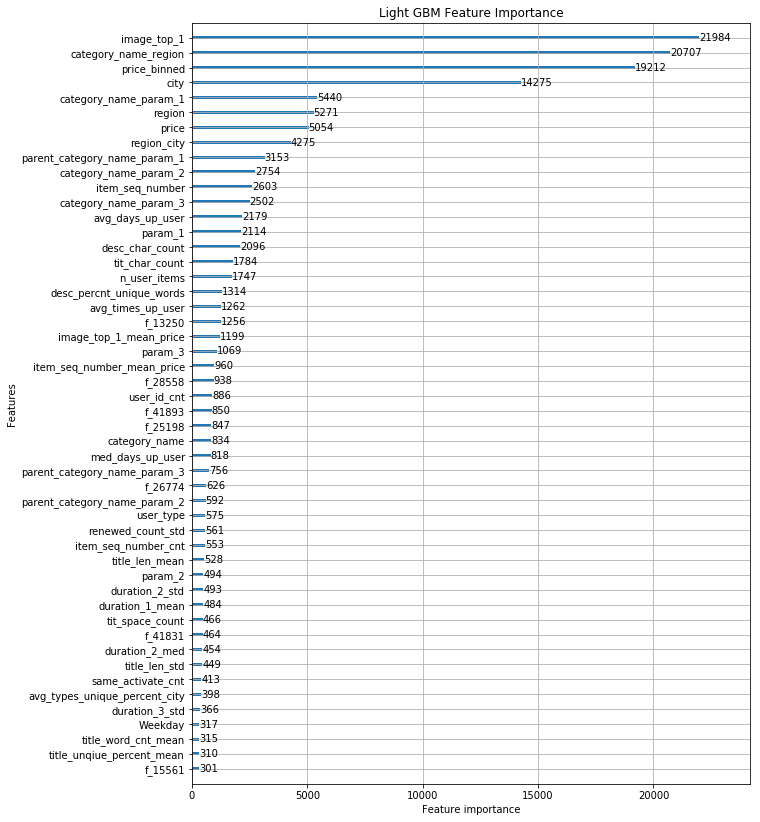

In [26]:
fig, ax = plt.subplots(figsize=(10, 14))
lgb.plot_importance(model, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.show()

In [27]:
prefix = 'lgbm_719_user_id_drop_'

In [28]:
pd.DataFrame(model.predict(val_X), columns=[prefix+'pred']).to_csv(prefix+'val_pred.csv', index=False)

In [29]:
del train_features, tr_X, val_X; gc.collect()

183

In [30]:
with open("all_features_dense.pickle", 'rb') as handle:
    comm_features = pickle.load(handle)
    comm_features.drop(drop_cols, axis=1, inplace=True)
    
with open("TF_IDF_W_BIN_C/tf_idf_features(with_bin).pickle", 'rb') as handle:
    text_features = pickle.load(handle)
    
all_features = hstack([csr_matrix(comm_features), text_features]).tocsr()

In [31]:
train_len = train_y.shape[0]
test_features = all_features[train_len:, :]
del all_features; gc.collect()

199

In [32]:
test_features.shape[0]

508438

In [33]:
test_pred = model.predict(test_features)

In [34]:
pd.DataFrame(test_pred, columns=[prefix+'pred']).to_csv(prefix+'test_pred.csv', index=False)

In [35]:
test_df = pd.read_csv("data/test.csv", usecols=['item_id'])

In [36]:
pd.DataFrame(np.clip(test_pred,0,1), 
             index=test_df.item_id,
             columns=['deal_probability']).to_csv(prefix+'submission.csv')